# **Step 1 : Data import and preparation**

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score)

from scipy import stats
import statsmodels.api as sm
from itertools import combinations
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.multitest import multipletests

from google.colab import files

Syllableerror_score = files.upload()
dict_Syllableerror_score = next(iter(Syllableerror_score))

df = pd.read_csv(dict_Syllableerror_score)
df = df.iloc[:,1:]
df = df.dropna()
df = df.reset_index(drop=True)

print(df)


Saving dysarthria_result_apple_corrected.csv to dysarthria_result_apple_corrected (2).csv
    disease  error_1  error_2  error_3  error_4
0         1        1        4        3        3
1         1        0        2        4        0
2         1        0        6        6        2
3         1        7        8        5       11
4         1        7        1        5        1
..      ...      ...      ...      ...      ...
69        0        0        1        1        1
70        0        0        0        2        1
71        0        0        0        3        2
72        0        0        0        3        1
73        0        1        0        2        1

[74 rows x 5 columns]


In [33]:
##### Dataset preparation #####

# Load your dataset (assuming df is predefined)
data = df
domain = 'disease'  #'Target variable'
features = ['error_1', 'error_2', 'error_3', 'error_4']  #'Features'
features_label = ['LBP', 'LAP', 'VP', 'MP'] #as abbv. of Labial-Placement, Lingual-Alveolar-Placement, Velo-Pharyngeal-Placement, and Mixed-Placement, respectively

# Prepare dataset
data_final = data[features + [domain]].dropna().reset_index(drop=True)

# Initialize violin plot
plt.rc("font", size=14)
sns.set(style="whitegrid")

# **Step 2 : 5-Fold Cross-Validation, Model fitting and evaluation, and Histograms of AUCs**

In [34]:
##### Define cross-validation and prepare hyperparameter #####

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for regularization strength (C)
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
param_grid = {"C": C}

In [35]:
##### Repeated stratified train–test evaluation (10,000 random splits) of logistic regression model AUC using each feature(sentence) and all four features combined ('Combined' sentence) #####

# Initialize results dictionary
auc_results = {feature: [] for feature in features_label + ['Combined']}
best_params_per_feature = {}

# Tune hyperparameters once per feature for each feature(sentence)
TUNE_RANDOM_STATE = 999  # any fixed number
for i, feature in enumerate(features):
    X = data_final[[feature]]
    y = data_final[domain]
    # Train-test split (70-30 stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=TUNE_RANDOM_STATE, stratify=y
    )
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # Grid Search with 5-Fold Cross validation
    lr_L1 = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1')
    lr_L2 = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2')
    search_cv_1 = GridSearchCV(lr_L1, param_grid, cv=kf, scoring='roc_auc')
    search_cv_2 = GridSearchCV(lr_L2, param_grid, cv=kf, scoring='roc_auc')
    search_cv_1.fit(X_train_scaled, y_train)
    search_cv_2.fit(X_train_scaled, y_train)
    # Choose best model based on validation score
    best_search = search_cv_1 if search_cv_1.best_score_ > search_cv_2.best_score_ else search_cv_2
    best_model = best_search.best_estimator_
    # Store tuned hyperparameters for bootstrap (random state shuffling) step
    label = features_label[i]
    best_params_per_feature[label] = {
        "penalty": best_model.penalty,
        "C": best_model.C,
        "solver": best_model.solver,
        "max_iter": best_model.max_iter,
        "tune_cv_auc": best_search.best_score_,
    }
    print(f"[{label}] Best penalty={best_model.penalty}, C={best_model.C:.4g}, CV AUC={best_search.best_score_:.3f}")

# Loop through random states for each feature
for random_state in range(1, 10001):
    for i, feature in enumerate(features):
        label = features_label[i]
        tuned = best_params_per_feature[label]
        X = data_final[[feature]]
        y = data_final[domain]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=random_state, stratify=y
        )
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # Fit only the tuned model
        model = LogisticRegression(
            max_iter=tuned["max_iter"],
            solver=tuned["solver"],
            penalty=tuned["penalty"],
            C=tuned["C"]
        )
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_results[label].append(auc)

# Tune hyperparameters for 'combined' features('combined' sentence)
TUNE_RANDOM_STATE = 999
X_all = data_final[features]
y = data_final[domain]
    # Train-test split (70-30 stratified)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.3, random_state=TUNE_RANDOM_STATE, stratify=y
)
    # Standardize features
scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
    # Grid Search with 5-Fold Cross-Validation
lr_L1_all = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1')
lr_L2_all = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2')
search_cv_1_all = GridSearchCV(lr_L1_all, param_grid, cv=kf, scoring='roc_auc')
search_cv_2_all = GridSearchCV(lr_L2_all, param_grid, cv=kf, scoring='roc_auc')
search_cv_1_all.fit(X_train_all_scaled, y_train_all)
search_cv_2_all.fit(X_train_all_scaled, y_train_all)
    # Choose best model based on validation score
best_search_all = search_cv_1_all if search_cv_1_all.best_score_ > search_cv_2_all.best_score_ else search_cv_2_all
best_model_all = best_search_all.best_estimator_
    # Store tuned hyperparameters for bootstrap step
best_params_combined = {
    "penalty": best_model_all.penalty,
    "C": best_model_all.C,
    "solver": best_model_all.solver,
    "max_iter": best_model_all.max_iter,
    "tune_cv_auc": best_search_all.best_score_,
}
print(f"[Combined] Best penalty={best_model_all.penalty}, C={best_model_all.C:.4g}, CV AUC={best_search_all.best_score_:.3f}")

# Loop through random states for 'combined' features
for random_state in range(1, 10001):
    X_all = data_final[features]
    y = data_final[domain]
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X_all, y, test_size=0.3, random_state=random_state, stratify=y
    )
    # Standardize features
    scaler_all = StandardScaler()
    X_train_all_scaled = scaler_all.fit_transform(X_train_all)
    X_test_all_scaled = scaler_all.transform(X_test_all)
    # Fit only the tuned model
    model_all = LogisticRegression(
        max_iter=best_params_combined["max_iter"],
        solver=best_params_combined["solver"],
        penalty=best_params_combined["penalty"],
        C=best_params_combined["C"]
    )
    model_all.fit(X_train_all_scaled, y_train_all)
    y_pred_proba_all = model_all.predict_proba(X_test_all_scaled)[:, 1]
    auc_all = roc_auc_score(y_test_all, y_pred_proba_all)
    auc_results['Combined'].append(auc_all)

# Convert results to DataFrame
auc_df = pd.DataFrame(auc_results)

# Calculate mean AUC, 95% CI, Median AUC, and IQR for each feature
summary_stats = {}
for feature in auc_df.columns:
    median_Auc = auc_df[feature].median()
    mean_auc = auc_df[feature].mean()
    ci_lower = auc_df[feature].quantile(0.025)
    ci_upper = auc_df[feature].quantile(0.975)
    q1 = auc_df[feature].quantile(0.25)
    q3 = auc_df[feature].quantile(0.75)
    iqr = q3 - q1
    summary_stats[feature] = {'Mean AUC': mean_auc, '95% CI': (ci_lower, ci_upper), 'Median AUC': median_Auc, 'IQR': iqr}

# Display summary statistics
summary_df = pd.DataFrame(summary_stats).T
print("Summary Statistics (Mean AUC, 95% CI, Median AUC, and IQR):")
print(summary_df)

[LBP] Best penalty=l2, C=1e-05, CV AUC=0.822
[LAP] Best penalty=l2, C=1e-05, CV AUC=0.857
[VP] Best penalty=l2, C=1e-05, CV AUC=0.731
[MP] Best penalty=l2, C=1e-05, CV AUC=0.713
[Combined] Best penalty=l2, C=0.1, CV AUC=0.891
Summary Statistics (Mean AUC, 95% CI, Median AUC, and IQR):
          Mean AUC                                    95% CI Median AUC  \
LBP       0.793849  (0.6363636363636364, 0.9242424242424243)   0.795455   
LAP        0.87235  (0.7424242424242424, 0.9848484848484849)      0.875   
VP        0.715576  (0.5303030303030303, 0.8863636363636364)   0.715909   
MP        0.662473                 (0.5, 0.8181818181818181)   0.666667   
Combined  0.881364  (0.7386363636363636, 0.9886363636363638)   0.886364   

               IQR  
LBP       0.098485  
LAP       0.083333  
VP           0.125  
MP        0.113636  
Combined  0.087121  


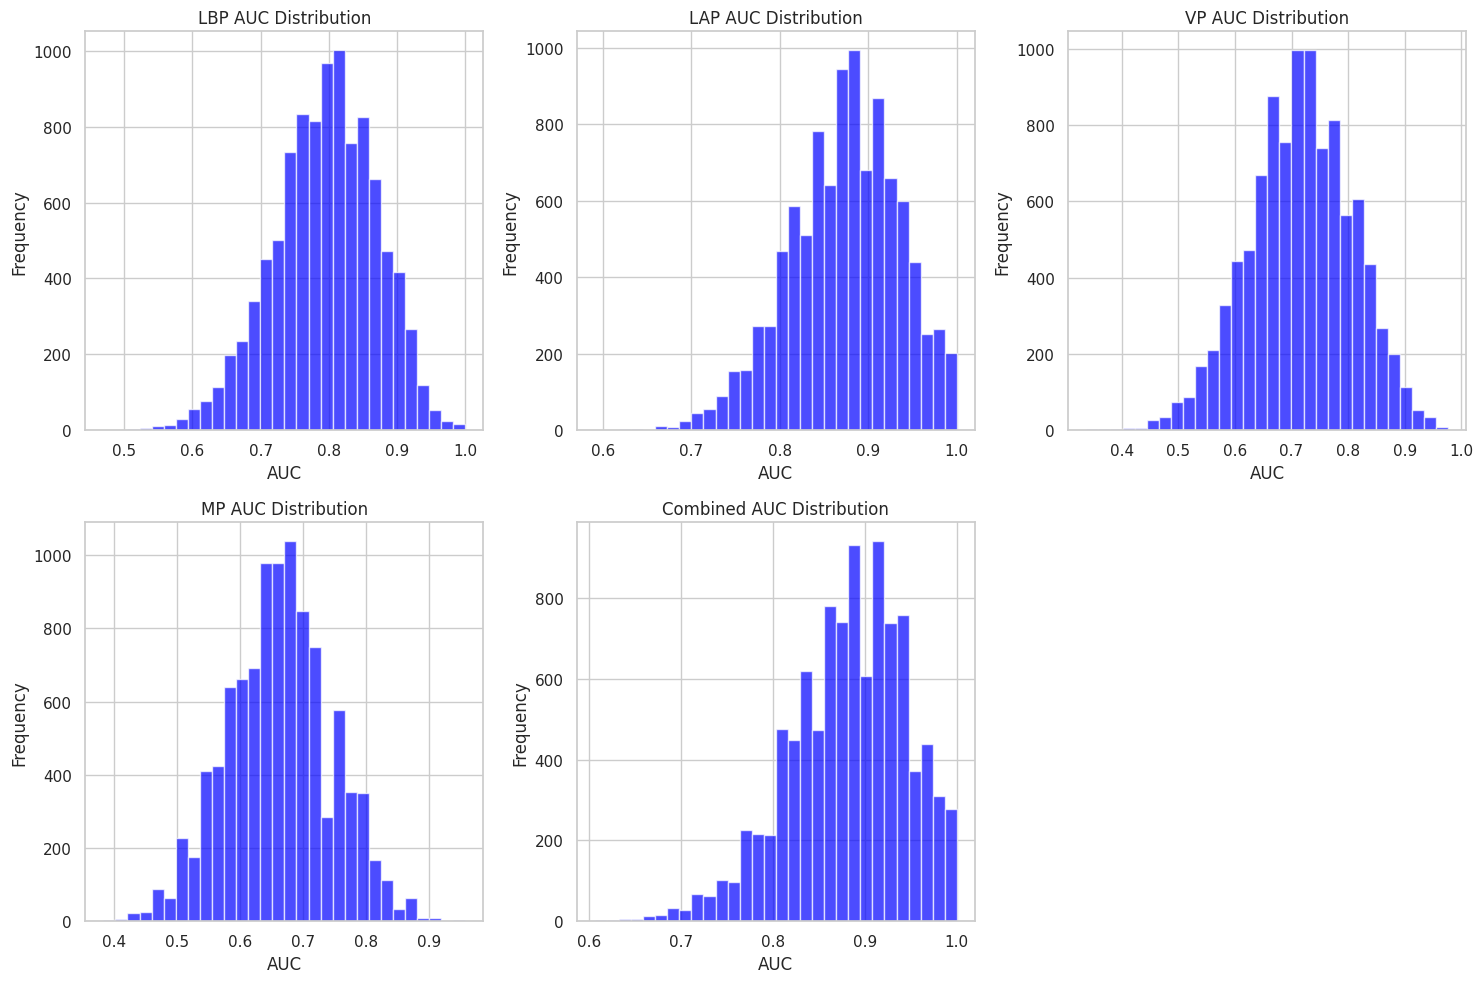

In [36]:
# Plot histograms of AUC for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(auc_df.columns):
    plt.subplot(2, 3, i + 1)
    plt.hist(auc_df[feature], bins=30, color='blue', alpha=0.7)
    plt.title(f'{feature} AUC Distribution')
    plt.xlabel('AUC')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# **Step 3 : Statistical analysis of AUC scores**

<Figure size 1000x400 with 0 Axes>

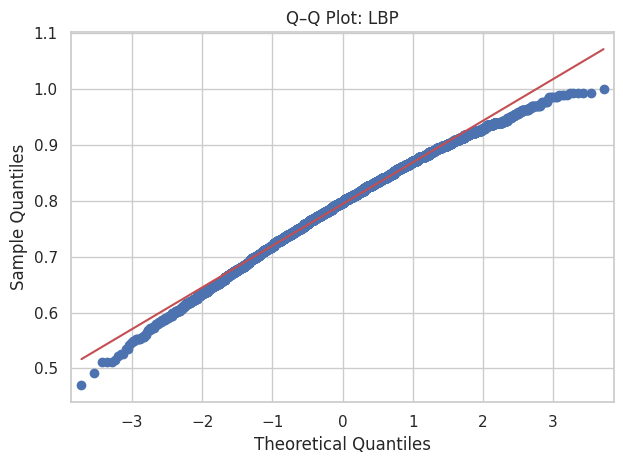

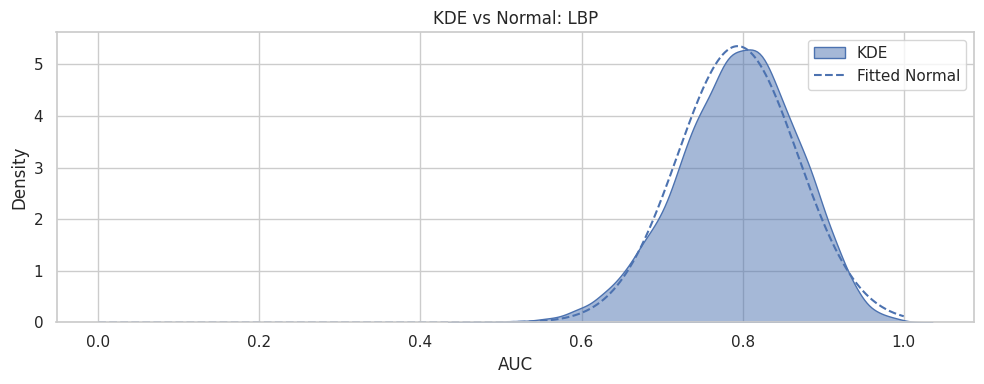

<Figure size 1000x400 with 0 Axes>

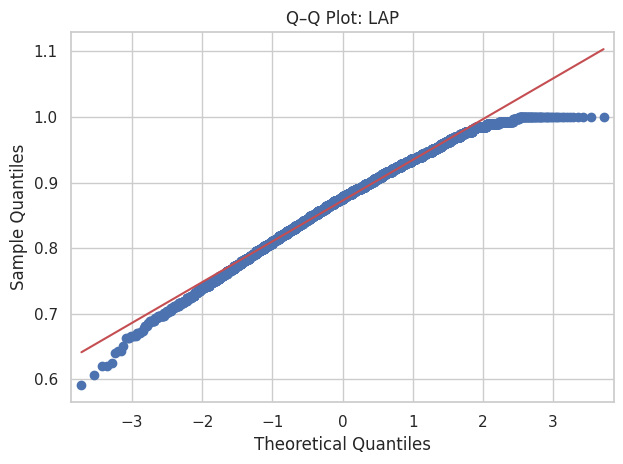

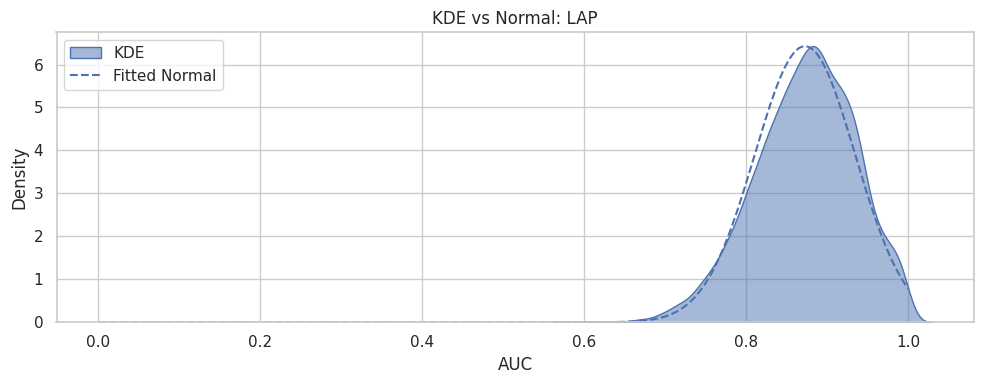

<Figure size 1000x400 with 0 Axes>

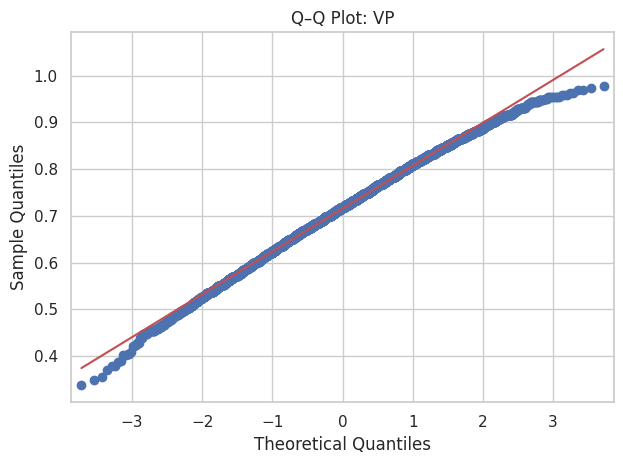

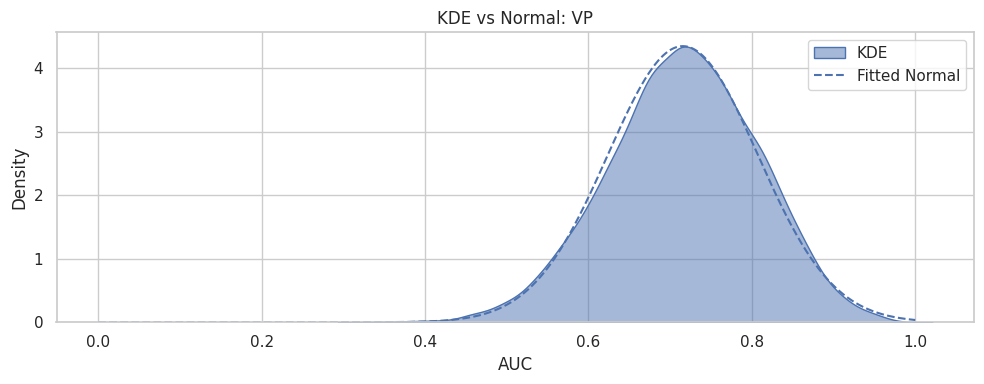

<Figure size 1000x400 with 0 Axes>

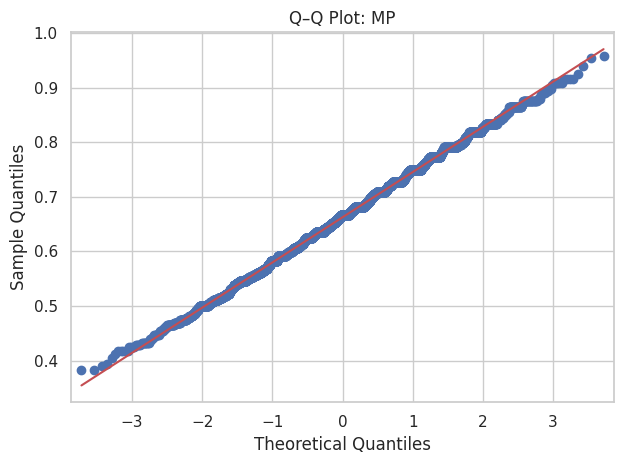

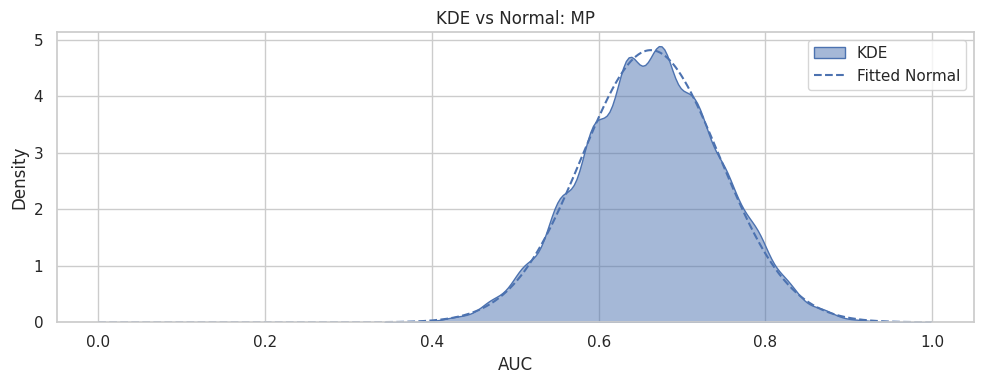

<Figure size 1000x400 with 0 Axes>

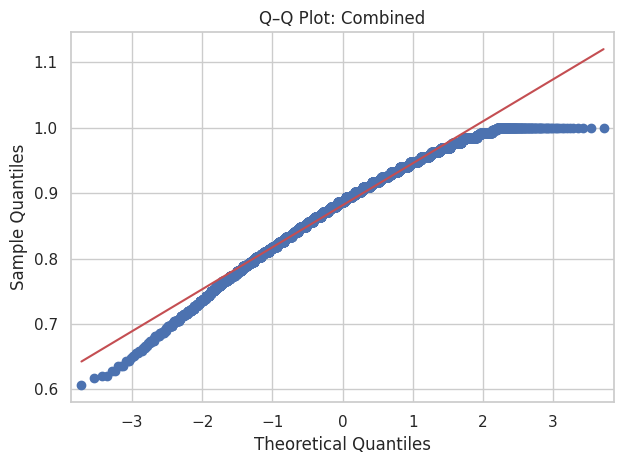

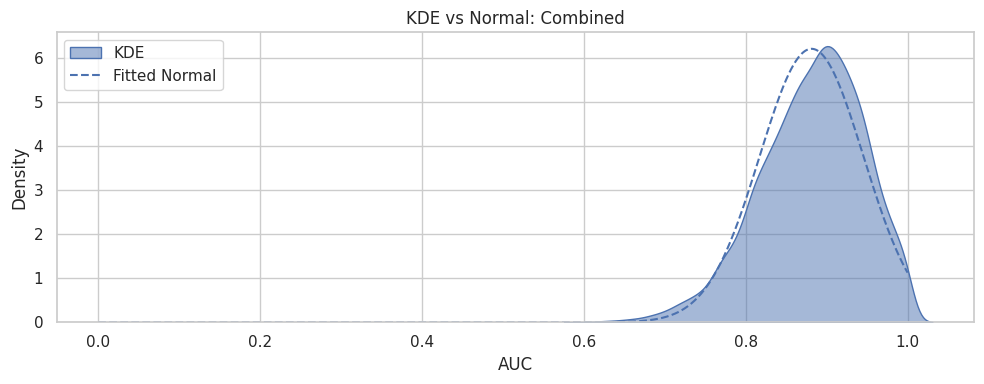

    feature      n  dagostino_stat   dagostino_p  anderson_stat  \
0       LBP  10000      157.091279  7.727910e-35      12.665673   
1       LAP  10000      212.609686  6.798189e-47      18.228510   
2        VP  10000       59.221943  1.380761e-13       4.228620   
3        MP  10000       10.014789  6.688307e-03       5.340278   
4  Combined  10000      428.577708  8.620514e-94      37.253183   

   anderson_crit_5pct  anderson_pass_5pct  lilliefors_stat  lilliefors_p  \
0               0.787               False         0.033929         0.001   
1               0.787               False         0.039090         0.001   
2               0.787               False         0.019184         0.001   
3               0.787               False         0.027145         0.001   
4               0.787               False         0.056441         0.001   

   looks_normal  
0         False  
1         False  
2         False  
3         False  
4         False  
     A         B  both_normal   

In [37]:
##### Normality testing of bootstrap AUC distributions and paired pairwise comparisons #####

# Define function for 'Normality tests'
def normality_tests_full(x: pd.Series, alpha: float = 0.05) -> dict:
    arr = x.dropna().to_numpy(dtype=float)
    n = len(arr)

    # 1 D’Agostino–Pearson
    da_stat, da_p = stats.normaltest(arr)

    # 2 Anderson–Darling
    ad = stats.anderson(arr, dist="norm")
    crit_5 = np.nan
    for sl, cv in zip(ad.significance_level, ad.critical_values):
        if sl == 5.0:
            crit_5 = cv
            break
    ad_pass = (not np.isnan(crit_5)) and (ad.statistic < crit_5)

    # 3 Lilliefors (KS-with-fitted-parameters)
    lf_stat, lf_p = lilliefors(arr, dist="norm")

    # Decision : consider "normal distribution" only if all three checks pass
    looks_normal = (da_p > alpha) and ad_pass and (lf_p > alpha)
    return {
        "n": n,
        "dagostino_stat": float(da_stat),
        "dagostino_p": float(da_p),
        "anderson_stat": float(ad.statistic),
        "anderson_crit_5pct": float(crit_5),
        "anderson_pass_5pct": bool(ad_pass),
        "lilliefors_stat": float(lf_stat),
        "lilliefors_p": float(lf_p),
        "looks_normal": bool(looks_normal)}


# Define function for 'Qualitative plots'
def plot_normality_diagnostics(x: pd.Series, name: str) -> None:
    """
    # Visual checks
    - Q–Q plot
    - KDE + fitted normal curve
    """
    arr = x.dropna().to_numpy(dtype=float)
    if len(arr) < 3:
        return

    # Q–Q plot
    plt.figure(figsize=(10, 4))
    sm.qqplot(arr, line="s")
    plt.title(f"Q–Q Plot: {name}")
    plt.tight_layout()
    plt.show()

    # KDE + fitted normal
    plt.figure(figsize=(10, 4))
    sns.kdeplot(arr, fill=True, alpha=0.5, label="KDE")

    mean, std = np.mean(arr), np.std(arr, ddof=1)
    xs = np.linspace(0, 1, 1000)
    if std > 0:
        plt.plot(xs, stats.norm.pdf(xs, loc=mean, scale=std), "--", label="Fitted Normal")

    plt.title(f"KDE vs Normal: {name}")
    plt.xlabel("AUC")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Define function for 'Pairwise testing of difference based on normality'
def pairwise_compare(
    df: pd.DataFrame,
    features: list,
    normal_flags: dict,
    alpha: float = 0.05,
    correction: str = "bonferroni",
    alternative_nonparam: str = "two-sided",
) -> pd.DataFrame:

    rows = []

    for a, b in combinations(features, 2):
        x = df[a].dropna()
        y = df[b].dropna()

        # Align indices for paired tests
        xy = pd.concat([x, y], axis=1, join="inner").dropna()
        x_use = xy.iloc[:, 0].to_numpy()
        y_use = xy.iloc[:, 1].to_numpy()

        both_normal = normal_flags.get(a, False) and normal_flags.get(b, False)
        if both_normal:
            stat, p = stats.ttest_rel(x_use, y_use)
            test_name = "paired t-test"
        else:
            stat, p = stats.wilcoxon(x_use, y_use, alternative=alternative_nonparam)
            test_name = "Wilcoxon signed-rank"

        rows.append({
            "A": a, "B": b,
            "both_normal": bool(both_normal),
            "test": test_name,
            "statistic": float(stat),
            "p_raw": float(p),
            "n_used": int(len(x_use))})
    out = pd.DataFrame(rows)

    # Multiple testing correction
    reject, p_corr, _, _ = multipletests(out["p_raw"].values, alpha=alpha, method=correction)
    out["p_corrected"] = p_corr
    out["reject_null"] = reject

    return out.sort_values(["p_corrected", "p_raw"]).reset_index(drop=True)

# Define function to run entire analysis
def run_distribution_tests(
    auc_df: pd.DataFrame,
    features: list,
    alpha: float = 0.05,
    do_plots: bool = False,
    correction: str = "bonferroni",
    alternative_nonparam: str = "two-sided",) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Normality summary
    normality_rows = []
    normal_flags = {}

    for f in features:
        res = normality_tests_full(auc_df[f], alpha=alpha)
        normal_flags[f] = res["looks_normal"]
        normality_rows.append({"feature": f, **res})

        if do_plots:
            plot_normality_diagnostics(auc_df[f], f)

    normality_summary = pd.DataFrame(normality_rows)

    # Pairwise tests
    pairwise_results = pairwise_compare(
        auc_df, features,
        normal_flags=normal_flags,
        alpha=alpha,
        correction=correction,
        alternative_nonparam=alternative_nonparam)
    return normality_summary, pairwise_results

# Run the acutal analysis
features_to_test = features_label + ["Combined"]

normality_summary, pairwise_results = run_distribution_tests(
    auc_df=auc_df,
    features=features_to_test,
    alpha=0.05,
    do_plots=True,
    correction="bonferroni",
    alternative_nonparam="two-sided")

print(normality_summary)
print(pairwise_results.head(20))


# **Step 4 : Violin plotting**

/tmp/ipython-input-1628230874.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-1628230874.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_cols_with_combined, rotation=0, ha="center", fontsize=14)


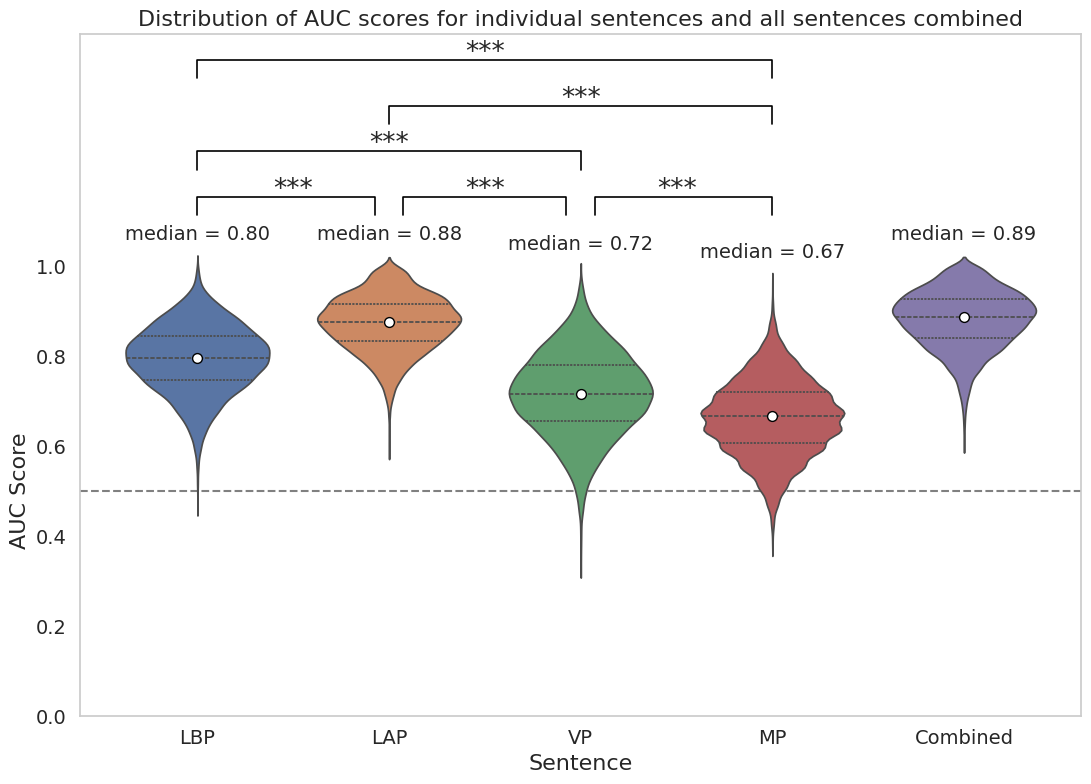

In [38]:
##### Violin plot of bootstrap AUC distributions with pairwise significance brackets #####

df = auc_df.copy()

plot_cols_with_combined = list(df.columns)
plot_cols_without_combined = list(df.columns[:-1])

# Use existing pairwise statistics for brackets
pvals = {}

pr = pairwise_results.copy()
use_p = "p_corrected" if "p_corrected" in pr.columns else "p_raw"

pr = pr[pr["A"].isin(plot_cols_without_combined) & pr["B"].isin(plot_cols_without_combined)].copy()
for _, r in pr.iterrows():
    a = str(r["A"]).strip()
    b = str(r["B"]).strip()
    pvals[(a, b)] = float(r[use_p])

def p_to_stars(p):
    if p is None or np.isnan(p):
        return "ns"
    if p < 1e-3:
        return "***"
    if p < 1e-2:
        return "**"
    if p < 5e-2:
        return "*"
    return "ns"

# Prepare long format and medians
df_melted = df[plot_cols_with_combined].melt(var_name="Feature", value_name="AUC")
medians = (
    df_melted.groupby("Feature", sort=False)["AUC"]
    .median()
    .reindex(plot_cols_with_combined))

# Draw violin plot
fig, ax = plt.subplots(figsize=(11, 8))
sns.violinplot(
    x="Feature",
    y="AUC",
    data=df_melted,
    palette=palette_map,
    ax=ax,
    inner="quartile",
    width=0.75)

ax.scatter(
    x=np.arange(len(plot_cols_with_combined)),
    y=medians.values,
    color="white",
    edgecolors="black",
    s=50,
    zorder=3)

ax.set_xticklabels(plot_cols_with_combined, rotation=0, ha="center", fontsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylabel("AUC Score", fontsize=16)
ax.set_xlabel("Sentence", fontsize=16)
ax.set_title("Distribution of AUC scores for individual sentences and all sentences combined", fontsize=16)
ax.grid(axis="y", visible=False)
ax.grid(axis="x", visible=False)
ax.axhline(y=0.5, color="grey", linestyle="--", zorder=0)

# Bracket layout parameters
height_step_factor = 0.06
h_factor = 2.0
star_gap_factor = 0.005
arm_extension_factor = 0.3
level_spacing_factor = 5.0
violin_width_factor = 0.4
median_label_offset = 0.05

max_y_without_combined = df[plot_cols_without_combined].max().max()
min_mean_without_combined = df[plot_cols_without_combined].mean().min()

height_step = (max_y_without_combined - min_mean_without_combined) * height_step_factor
if not np.isfinite(height_step) or height_step <= 0:
    height_step = 0.02

bracket_levels = []
adjacent_pairs = [(plot_cols_without_combined[i], plot_cols_without_combined[i + 1])
                  for i in range(len(plot_cols_without_combined) - 1)]
if adjacent_pairs:
    bracket_levels.append(adjacent_pairs)

two_apart_lbp_vp = [("LBP", "VP")]
three_apart_lap_mp = [("LAP", "MP")]
three_apart_lbp_mp = [("LBP", "MP")]

if two_apart_lbp_vp:
    bracket_levels.append(two_apart_lbp_vp)
if three_apart_lap_mp:
    bracket_levels.append(three_apart_lap_mp)
if three_apart_lbp_mp:
    bracket_levels.append(three_apart_lbp_mp)

if len(plot_cols_without_combined) > 1:
    max_q3_without_combined = df[plot_cols_without_combined].quantile(0.75).max()
    y_level_base = max_q3_without_combined + arm_extension_factor * (max_y_without_combined - min_mean_without_combined) + median_label_offset * 1.5
else:
    y_level_base = max_y_without_combined + arm_extension_factor * (max_y_without_combined - min_mean_without_combined) + median_label_offset * 1.5

bracket_arm_lengths = {
    ("LBP", "LAP"): {"left_arm_length": 0.5, "right_arm_length": 0.53},
    ("LAP", "VP"): {"left_arm_length": 0.53, "right_arm_length": 0.53},
    ("VP", "MP"): {"left_arm_length": 0.53, "right_arm_length": 0.5},
    ("LBP", "VP"): {"left_arm_length": 0.5, "right_arm_length": 0.5},
    ("LAP", "MP"): {"left_arm_length": 0.5, "right_arm_length": 0.5},
    ("LBP", "MP"): {"left_arm_length": 0.5, "right_arm_length": 0.5},}

current_offset = 0
y_levels = {}

for level_i, level_pairs in enumerate(bracket_levels):
    level_offset_factor = 1.0 if level_i == 0 else level_spacing_factor
    y_level = y_level_base + height_step * (1 + current_offset * level_offset_factor)
    y_levels[level_i] = y_level

    for a, b in level_pairs:
        p = pvals.get((a, b), pvals.get((b, a), np.nan))
        stars = p_to_stars(p)
        if stars == "ns":
            continue

        xi = plot_cols_without_combined.index(a)
        xj = plot_cols_without_combined.index(b)
        x1_center = xi
        x2_center = xj

        arms = bracket_arm_lengths.get((a, b), bracket_arm_lengths.get((b, a), {"left_arm_length": 0.5, "right_arm_length": 0.5}))
        left_arm_length = arms["left_arm_length"]
        right_arm_length = arms["right_arm_length"]

        x1_adj = x1_center + (x2_center - x1_center) * (left_arm_length - 0.5) * (1 / violin_width_factor)
        x2_adj = x2_center - (x2_center - x1_center) * (right_arm_length - 0.5) * (1 / violin_width_factor)

        y = y_level
        h = height_step * h_factor

        ax.plot([x1_adj, x1_adj, x2_adj, x2_adj], [y, y + h, y + h, y], lw=1.2, c="black")
        ax.text((x1_center + x2_center) / 2, y + (h / 1.5), stars, ha="center", va="bottom", fontsize=19)

    if level_pairs:
        current_offset += 1

# Median AUC labels above each violin
for i, feature in enumerate(plot_cols_with_combined):
    median_auc = float(medians.loc[feature])
    text_y_position = df[feature].max() + median_label_offset
    ax.text(i, text_y_position, f"median = {median_auc:.2f}", ha="center", va="bottom", fontsize=14)

# Set y-ticks and move y-label to AUC=0.5
ax.set_yticks(np.arange(0.0, 1.1, 0.2))

ymin, ymax = ax.get_ylim()
y_frac = (0.5 - ymin) / (ymax - ymin) if ymax > ymin else 0.5
y_frac = min(max(y_frac, 0.0), 1.0)

x_current, _ = ax.yaxis.get_label().get_position()
ax.yaxis.set_label_coords(x_current - 0.05, y_frac)

plt.tight_layout()

plt.savefig("auc_violin_stripplot.png", dpi=500, bbox_inches="tight")
plt.savefig("auc_violin_stripplot.svg", format="svg", bbox_inches="tight")

plt.show()